In [ ]:
!pip install opencv-contrib-python-headless
!wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 9.5 MB/s eta 0:00:00
--2024-05-29 07:34:58--  https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb [following]
--2024-05-29 07:34:59--  https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x4.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38573255 (37M) [application/octet-stream]
Saving to: ‘EDSR_x4.pb’

EDSR_x4.pb          100%[===================>]  36.79M   148MB/s    in 0.2s    

2024-05-29 07:3

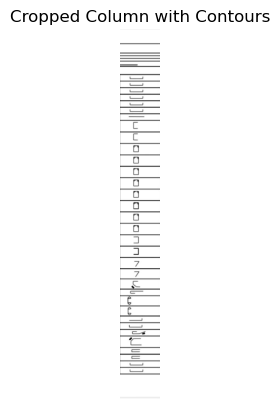

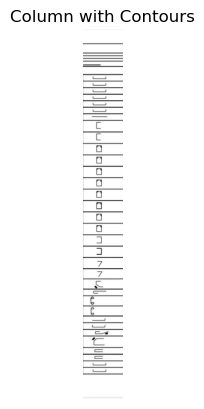

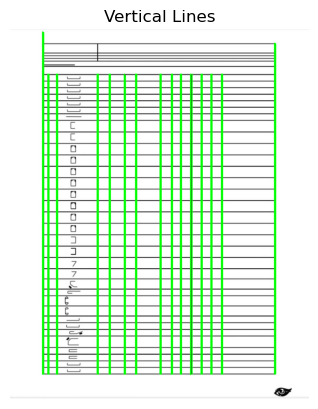

In [1]:
#new
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image using OpenCV
img_path = "p.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred_img, 50, 150, apertureSize=3)

# Find contours using hierarchical contouring
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Detect lines using probabilistic Hough transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw lines on a copy of the original image
lines_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
vertical_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < abs(y1 - y2):
            cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            vertical_lines.append(int((x1 + x2) / 2))

# Sort vertical line x-coordinates
vertical_lines.sort()

# Function to filter out contours that are too close to vertical lines
def filter_contours(contours, x1, x2, margin=5):
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x1 + margin < x < x2 - margin:
            filtered_contours.append(contour)
    return filtered_contours

# Variable to store the column with the most contours
max_contours = 0
best_column_img = None
best_column_contours = None
best_x1 = 0
best_x2 = 0

# Iterate over pairs of vertical lines to find contours between them
for i in range(len(vertical_lines) - 1):
    x1 = vertical_lines[i]
    x2 = vertical_lines[i + 1]

    # Filter contours within the current column
    column_contours = filter_contours(contours, x1, x2)

    # If this column has more contours, update the best column
    if len(column_contours) > max_contours:
        max_contours = len(column_contours)
        best_column_img = img[:, x1:x2]
        best_column_contours = column_contours
        best_x1 = x1
        best_x2 = x2

# If the best column is found, display and save it
if best_column_img is not None:
    # Display the cropped column
    plt.imshow(best_column_img, cmap='gray')
    plt.axis('off')
    plt.title("Cropped Column with Contours")
    plt.show()
    cv2.imwrite(f"cropped_column.png", best_column_img)

    # Draw contours on the column image for visualization
    best_column_contour_img = cv2.cvtColor(best_column_img, cv2.COLOR_GRAY2BGR)
    for contour in best_column_contours:
        cv2.drawContours(best_column_contour_img, [contour], -1, (0, 255, 0), 2)

    # Display the column with contours
    plt.imshow(best_column_contour_img)
    plt.axis('off')
    plt.title("Column with Contours")
    plt.show()

# Display the image with detected vertical lines for debugging
plt.imshow(lines_img)
plt.title('Vertical Lines')
plt.axis('off')
plt.show()


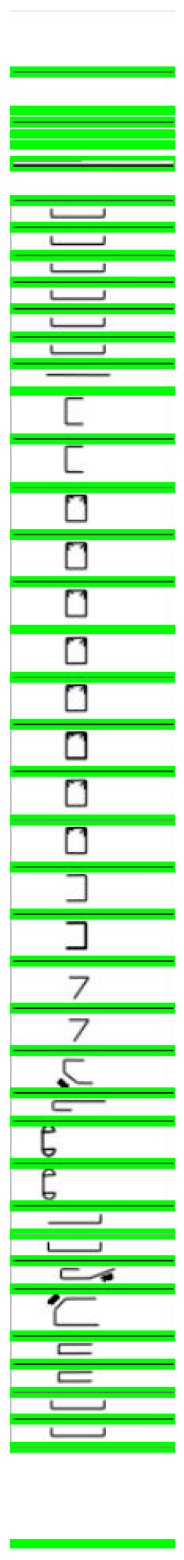

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the cropped column image
cropped_column_img = cv2.imread("cropped_column.png", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

# Apply adaptive thresholding to binarize the image
binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

# Apply morphological closing to connect nearby edges and smoothen the lines
kernel = np.ones((1, 5), np.uint8)
closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

# Find horizontal lines using morphological operations
horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours of horizontal lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter horizontal lines based on length and horizontal coverage
filtered_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
        filtered_lines.append(contour)

# Draw the filtered horizontal lines on a copy of the original image
lines_img = cv2.cvtColor(cropped_column_img, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x, y, w, h = cv2.boundingRect(line)
    cv2.rectangle(lines_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with filtered horizontal lines
plt.figure(figsize=(20, 20))
plt.imshow(lines_img)
plt.axis('off')
plt.show()

In [3]:
import cv2
import numpy as np
import os

def is_image_blank(image, blank_threshold=0.98, min_non_blank_pixels=100):
    # Calculate the percentage of white pixels in the image
    white_pixels = np.sum(image >= 200)  # Assuming white pixels have intensity >= 200
    total_pixels = image.size
    white_ratio = white_pixels / total_pixels

    # Check if the image has a large enough percentage of white pixels to be considered blank
    if white_ratio > blank_threshold:
        # Check if there are enough non-blank pixels to avoid mistakenly removing data rows
        non_blank_pixels = total_pixels - white_pixels
        if non_blank_pixels < min_non_blank_pixels:
            return True  # Image is considered blank
    return False  # Image is not blank

# Read the cropped column image
cropped_column_img = cv2.imread("cropped_column.png", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise
blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)

# Apply adaptive thresholding to binarize the image
binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)

# Apply morphological closing to connect nearby edges and smoothen the lines
kernel = np.ones((1, 5), np.uint8)
closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)

# Find horizontal lines using morphological operations
horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours of horizontal lines
contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter horizontal lines based on length and horizontal coverage
filtered_lines = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 0.9 * cropped_column_img.shape[1]:  # Check if line spans entire width
        filtered_lines.append(contour)

# Sort filtered lines by y-coordinate
filtered_lines.sort(key=lambda c: cv2.boundingRect(c)[1])

# Define the output folder
output_folder = "Shapes"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to crop and save rows
def crop_and_save_rows(lines):
    for i in range(len(lines) - 1):
        x1, y1, w1, h1 = cv2.boundingRect(lines[i])
        x2, y2, w2, h2 = cv2.boundingRect(lines[i + 1])

        # Crop the region between two horizontal lines
        row_img = cropped_column_img[y1 + h1 : y2, :]

        # Check if the cropped row has sufficient width and is not blank
        if row_img.shape[1] > 5 and not is_image_blank(row_img):
            # Save the cropped row image
            cv2.imwrite(os.path.join(output_folder, f"row_{i + 1}.png"), row_img)

# Crop and save rows
crop_and_save_rows(filtered_lines)

# Print the number of saved rows
num_rows_saved = len(os.listdir(output_folder))
print(f"{num_rows_saved} rows saved in the '{output_folder}' folder.")


33 rows saved in the 'Shapes' folder.


In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def is_image_blank(image, blank_threshold=0.98, min_non_blank_pixels=100):
    white_pixels = np.sum(image >= 200)  # Assuming white pixels have intensity >= 200
    total_pixels = image.size
    white_ratio = white_pixels / total_pixels

    if white_ratio > blank_threshold:
        non_blank_pixels = total_pixels - white_pixels
        if non_blank_pixels < min_non_blank_pixels:
            return True  # Image is considered blank
    return False  # Image is not blank

def upscale_image(image, scale_factor=4, model_path="EDSR_x4.pb"):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel("edsr", scale_factor)

    # Convert grayscale image to 3-channel image
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    upscaled_image = sr.upsample(image)
    return upscaled_image

def process_image(image_path, output_folder="Shapes", model_path="EDSR_x4.pb"):
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return

    cropped_column_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if cropped_column_img is None:
        print(f"Failed to read the image: {image_path}")
        return

    blurred_img = cv2.GaussianBlur(cropped_column_img, (5, 5), 0)
    binary_image_adaptive = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5)
    kernel = np.ones((1, 5), np.uint8)
    closed_img = cv2.morphologyEx(binary_image_adaptive, cv2.MORPH_CLOSE, kernel)
    horizontal_lines = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_lines = [contour for contour in contours if cv2.boundingRect(contour)[2] > 0.9 * cropped_column_img.shape[1]]
    filtered_lines.sort(key=lambda c: cv2.boundingRect(c)[1])

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    def crop_and_save_rows(lines):
        for i in range(len(lines) - 1):
            x1, y1, w1, h1 = cv2.boundingRect(lines[i])
            x2, y2, w2, h2 = cv2.boundingRect(lines[i + 1])

            row_img = cropped_column_img[y1 + h1:y2, :]
            if row_img.shape[1] > 5 and not is_image_blank(row_img):
                upscaled_row_img = upscale_image(row_img, model_path=model_path)

                # Display original and upscaled images
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title('Original Image')
                plt.imshow(row_img, cmap='gray')
                plt.subplot(1, 2, 2)
                plt.title('Upscaled Image')
                plt.imshow(cv2.cvtColor(upscaled_row_img, cv2.COLOR_BGR2GRAY), cmap='gray')
                plt.show()

                # Overwrite the original row image with the upscaled row image
                cv2.imwrite(os.path.join(output_folder, f"row_{i + 1}.png"), upscaled_row_img)

    crop_and_save_rows(filtered_lines)
    num_rows_saved = len(os.listdir(output_folder))
    print(f"{num_rows_saved} rows saved in the '{output_folder}' folder.")

# Run the processing function
process_image("cropped_column.png", model_path="EDSR_x4.pb")

AttributeError: module 'cv2.dnn_superres' has no attribute 'DnnSuperResImpl_create'

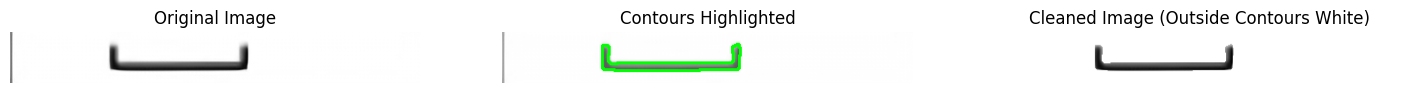

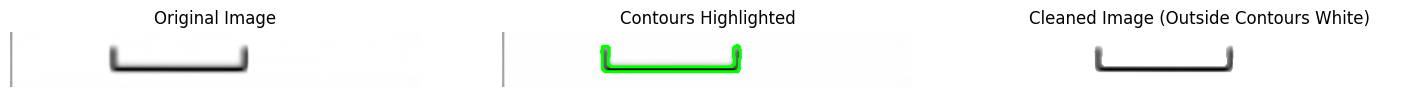

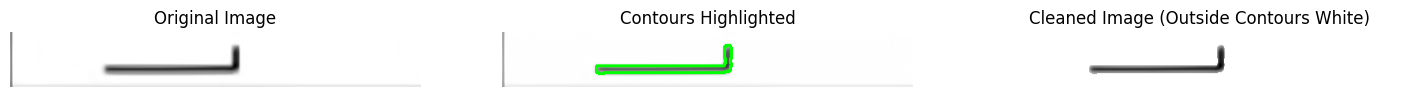

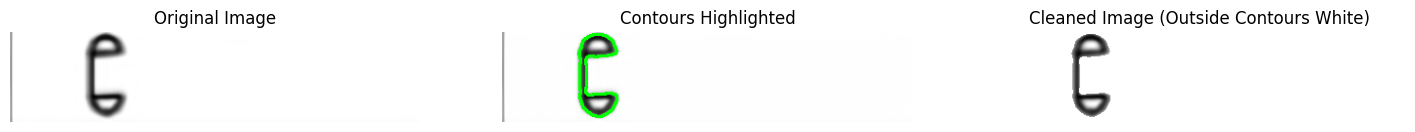

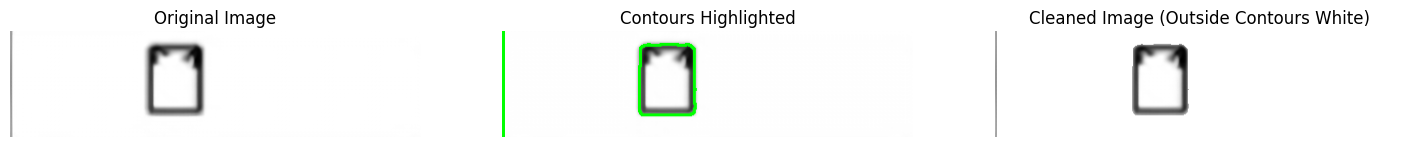

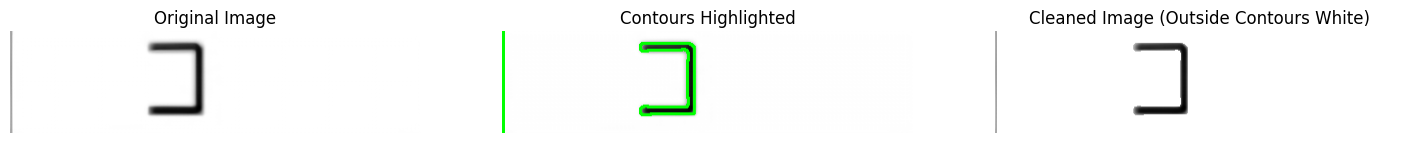

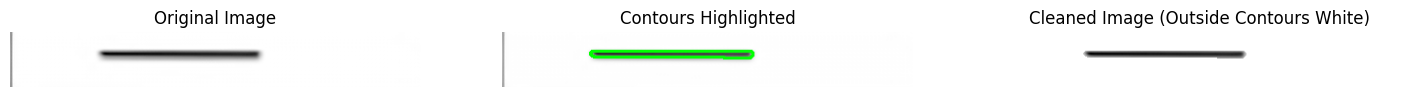

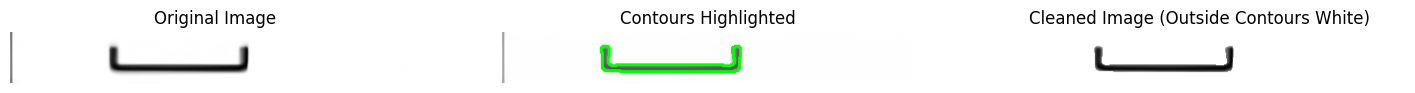

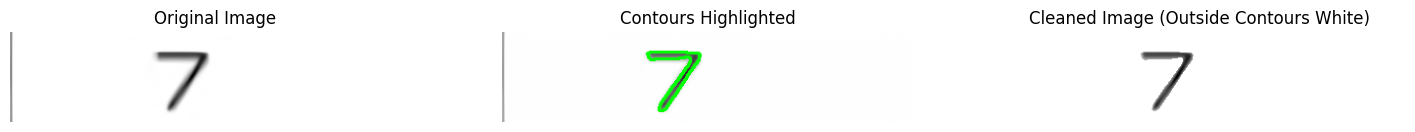

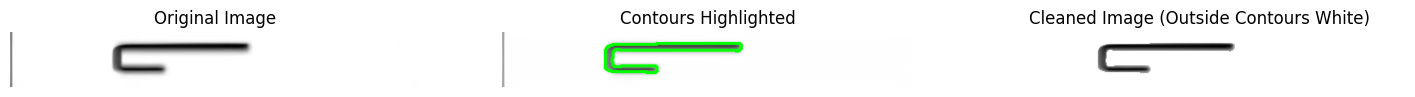

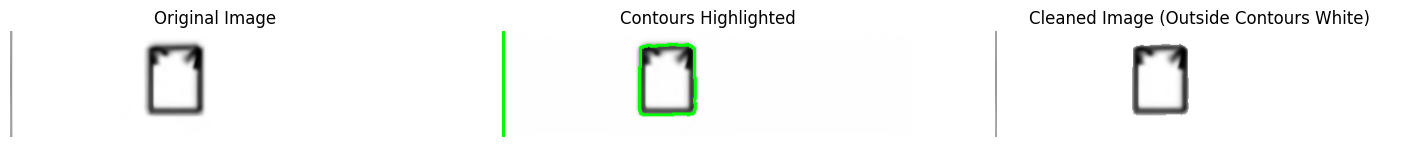

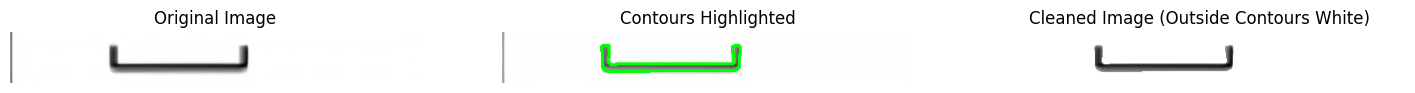

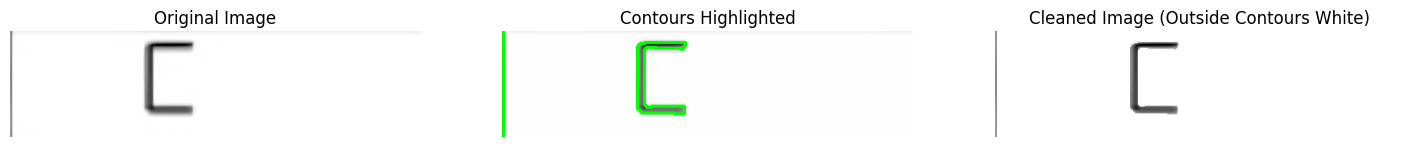

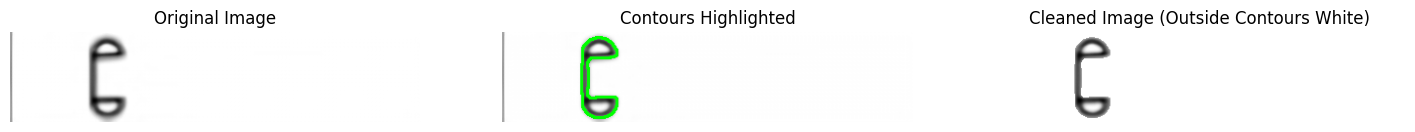

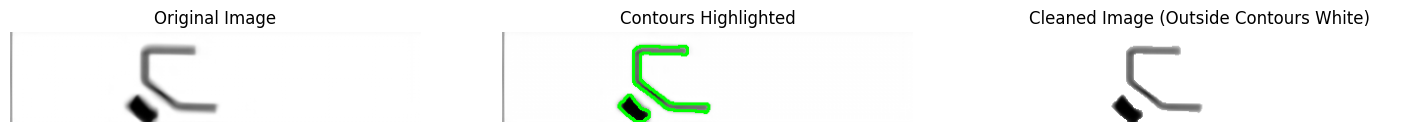

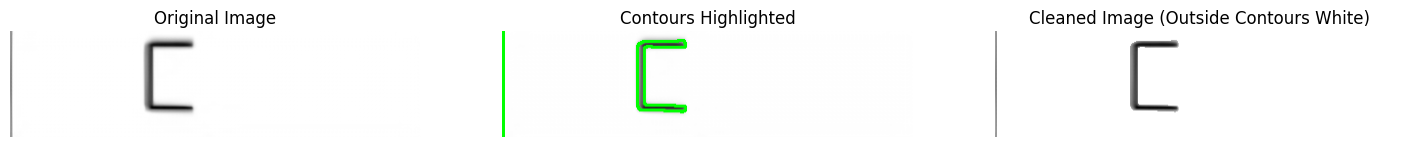

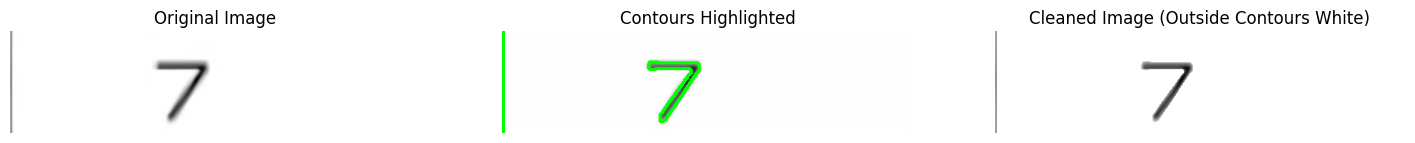

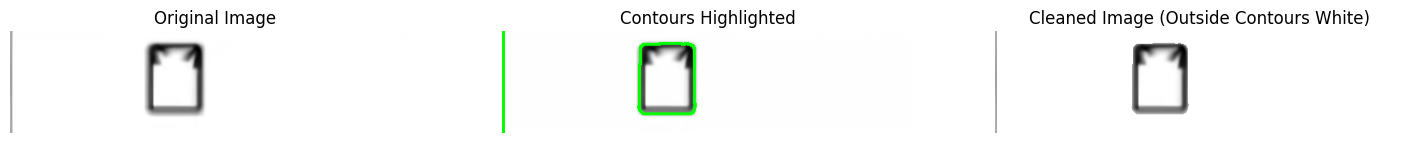

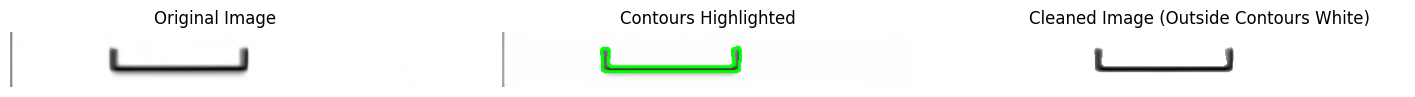

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to remove patches from an image and display the result
def remove_patches_and_display(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error: Unable to load the image '{image_path}'. Check the file path.")
        return

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding to create a binary image
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
    )

    # Perform morphological operations to refine the binary image
    kernel = np.ones((3, 3), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small noise
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

    # Create a mask filled with white (same size as the original image)
    mask = np.ones_like(binary_image) * 255

    # Draw contours on the mask and fill them with black
    cv2.drawContours(mask, contours, -1, 0, thickness=cv2.FILLED)

    # Create the cleaned image by turning everything outside the contours white
    cleaned_image = cv2.bitwise_or(image, mask)

    # Display the original image, contours, and cleaned image
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Contours highlighted on the original image
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2)
    ax[1].imshow(contour_image)
    ax[1].set_title('Contours Highlighted')
    ax[1].axis('off')

    # Cleaned image (everything outside the contours is white)
    ax[2].imshow(cleaned_image, cmap='gray')
    ax[2].set_title('Cleaned Image (Outside Contours White)')
    ax[2].axis('off')

    plt.show()

# Path to the folder containing the images
folder_path = "Shapes"

# Iterate over each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Construct the full path to the image
        image_path = os.path.join(folder_path, filename)

        # Remove patches and display the result
        remove_patches_and_display(image_path)


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Folder path containing the cropped images
image_folder = "Shapes"

# Gaussian blur parameters
gaussian_ksize = (3, 3)
gaussian_sigma = 0  # Default sigma value for Gaussian blur

# Dilation kernel and iterations
dilation_kernel = np.ones((3, 3), np.uint8)
dilation_iterations = 2  # Number of dilation iterations

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply Gaussian blur for noise reduction
            blurred_img = cv2.GaussianBlur(image, gaussian_ksize, gaussian_sigma)

            # Apply dilation to enhance edges
            dilated_img = cv2.dilate(blurred_img, dilation_kernel, dilation_iterations)

            # Shi-Tomasi corner detection
            corners = cv2.goodFeaturesToTrack(
                dilated_img, maxCorners=300, qualityLevel=0.01, minDistance=30
            )

            # Visualize the image, corners, and bends
            plt.figure(figsize=(12, 6))

            # Plot the original image
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title(f"Original Image: {image_file}")
            plt.axis('off')

            # Plot the dilated image with corners
            plt.subplot(1, 2, 2)
            plt.imshow(dilated_img, cmap='gray')
            plt.title(f"Dilated Image: {image_file}")

            if corners is not None:
                corners = np.int0(corners)  # Convert to integer coordinates

                # Plot the corners on the image
                for corner in corners:
                    x, y = corner.ravel()  # Get x and y coordinates
                    plt.plot(x, y, 'ro', ms=5)  # Red dots for corners

                # Print the number of corners detected
                num_corners = len(corners)
                print(f"Image: {image_file}, Number of corners detected: {num_corners}")
            else:
                print(f"Image: {image_file}, No corners detected")

            # Show the plot
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")


<ipython-input-10-f17cd27972fd>:104: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)  # Convert to integer coordinates


Image: row_7.png
Number of corners: 6
Number of overlaps: 4
Number of bends: 4



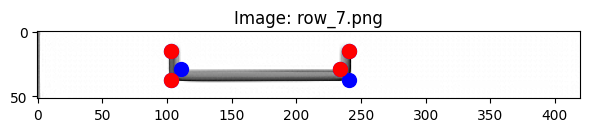

Image: row_8.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



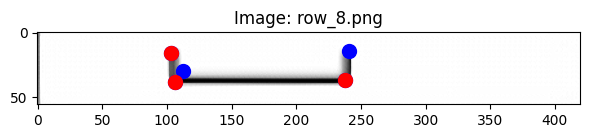

Image: row_32.png
Number of corners: 4
Number of overlaps: 1
Number of bends: 1



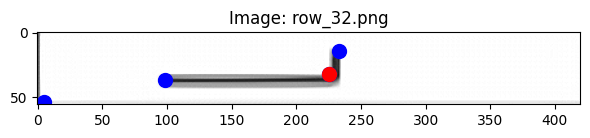

Image: row_30.png
Number of corners: 10
Number of overlaps: 7
Number of bends: 7



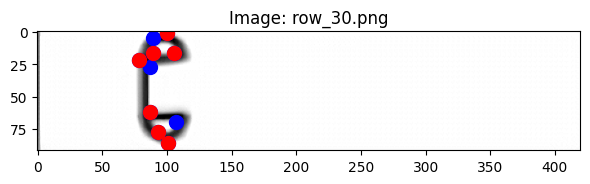

Image: row_18.png
Number of corners: 10
Number of overlaps: 7
Number of bends: 7



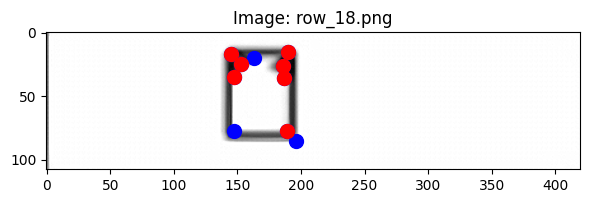

Image: row_25.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



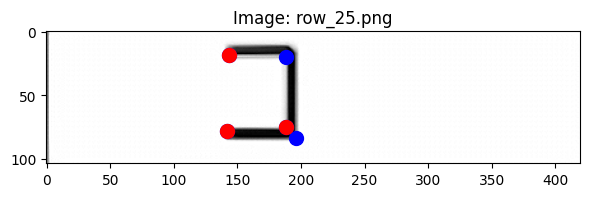

Image: row_13.png
Number of corners: 2
Number of overlaps: 0
Number of bends: 0



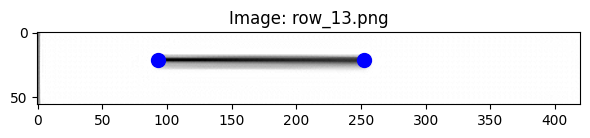

Image: row_10.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



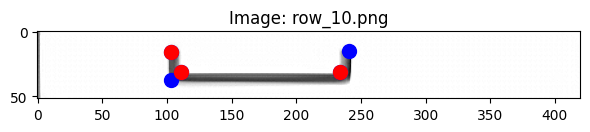

Image: row_27.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



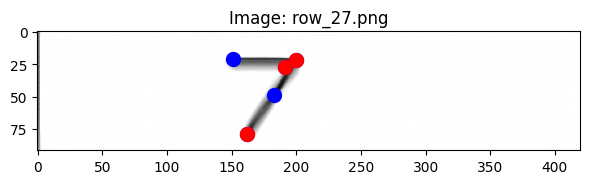

Image: row_29.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



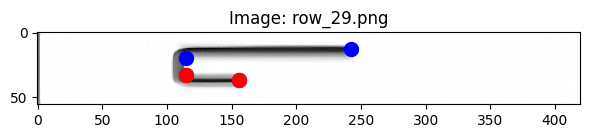

Image: row_22.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



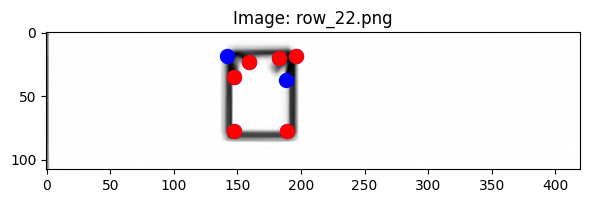

Image: row_12.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



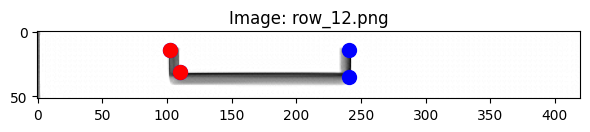

Image: row_14.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



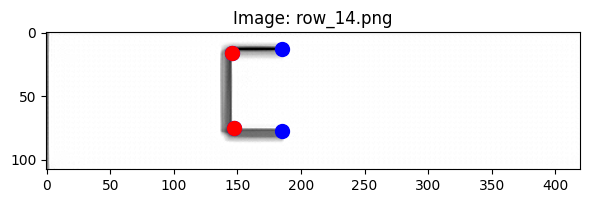

Image: row_31.png
Number of corners: 9
Number of overlaps: 7
Number of bends: 7



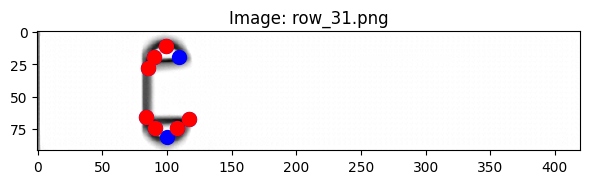

Image: row_28.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



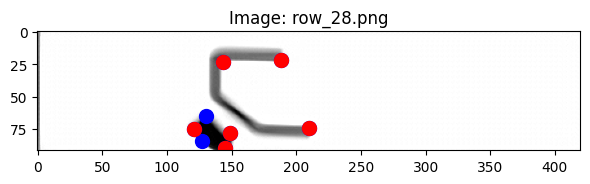

Image: row_15.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



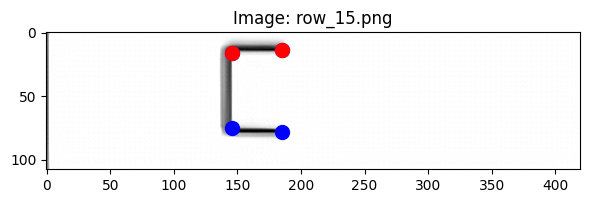

Image: row_26.png
Number of corners: 3
Number of overlaps: 1
Number of bends: 1



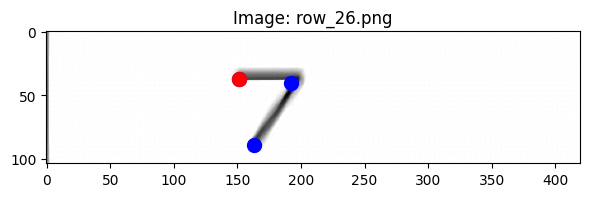

Image: row_17.png
Number of corners: 8
Number of overlaps: 5
Number of bends: 5



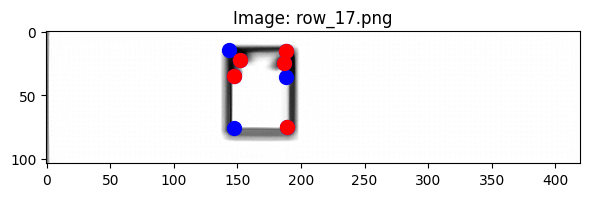

Image: row_11.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



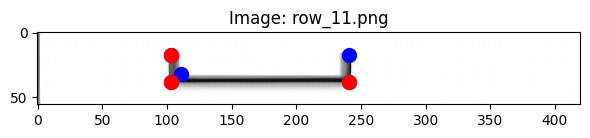

Image: row_24.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



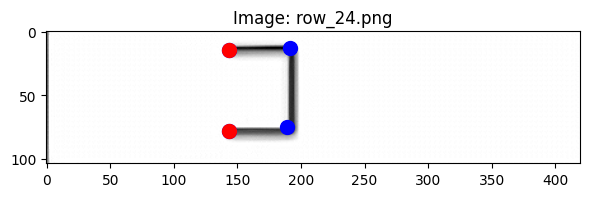

Image: row_37.png
Number of corners: 5
Number of overlaps: 3
Number of bends: 3



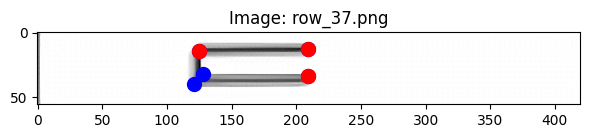

Image: row_9.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



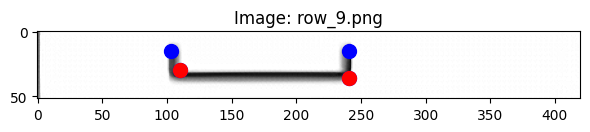

Image: row_36.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



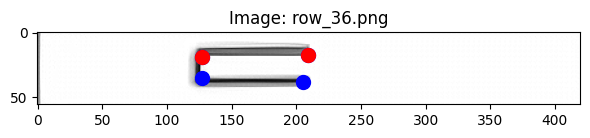

Image: row_39.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



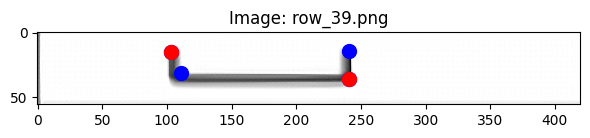

Image: row_38.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



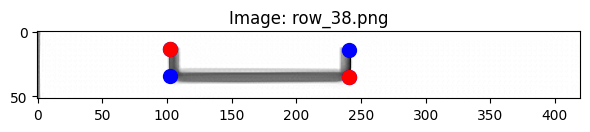

Image: row_23.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



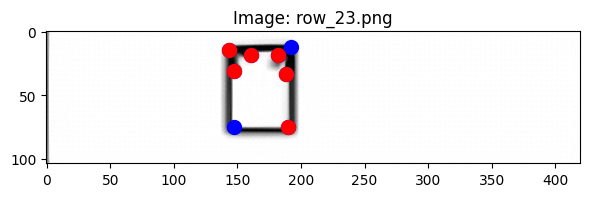

Image: row_34.png
Number of corners: 9
Number of overlaps: 7
Number of bends: 7



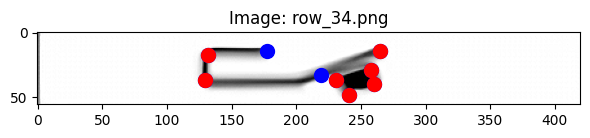

Image: row_35.png
Number of corners: 11
Number of overlaps: 9
Number of bends: 9



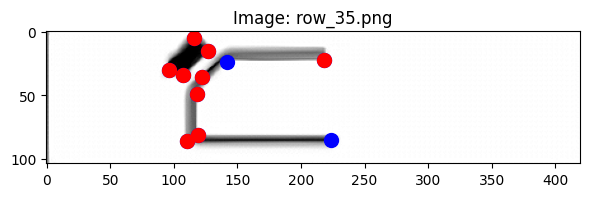

Image: row_21.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



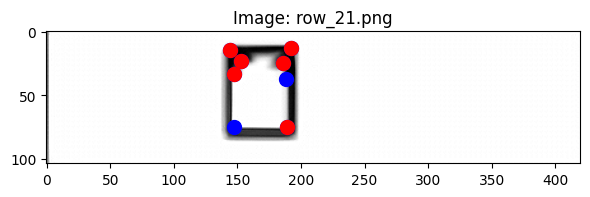

Image: row_19.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



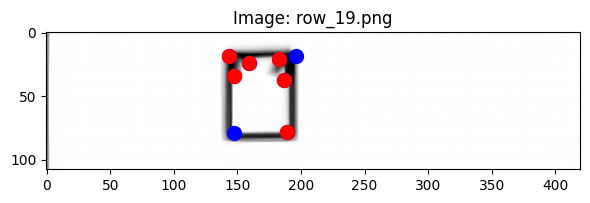

Image: row_16.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



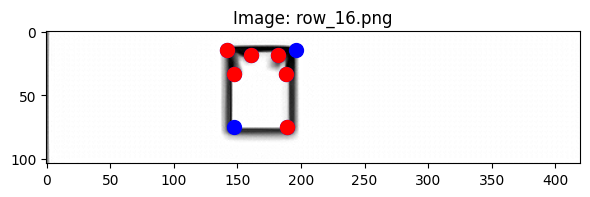

Image: row_20.png
Number of corners: 8
Number of overlaps: 6
Number of bends: 6



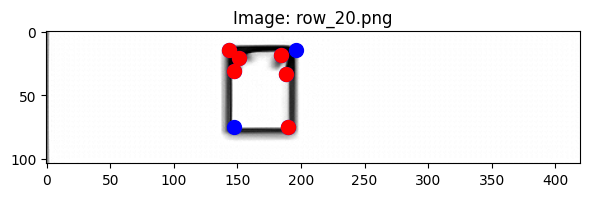

Image: row_33.png
Number of corners: 4
Number of overlaps: 2
Number of bends: 2



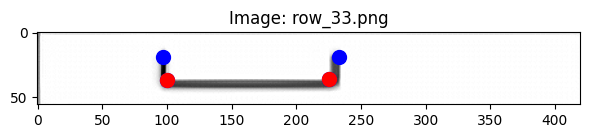

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def is_shape_closed(corners, threshold=10):
    """ Check if the shape is closed by comparing the distance between the first and last corners. """
    if len(corners) < 3:
        return False  # A closed shape needs at least 3 points

    start_corner = corners[0].ravel()
    end_corner = corners[-1].ravel()
    distance = np.linalg.norm(start_corner - end_corner)

    return distance <= threshold

def line_segments_from_corners(corners):
    """ Create line segments from detected corners. """
    segments = []
    for i in range(len(corners) - 1):
        x1, y1 = corners[i].ravel()
        x2, y2 = corners[i + 1].ravel()
        segments.append(((x1, y1), (x2, y2)))
    return segments

def calculate_angle(line1, line2):
    """ Calculate the angle between two lines. """
    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2

    # Vectors
    v1 = np.array([x2 - x1, y2 - y1])
    v2 = np.array([x4 - x3, y4 - y3])

    # Calculate the angle between the vectors
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_degrees = np.degrees(angle)

    return angle_degrees

def identify_overlap_corners(corners, segments, angle_threshold=20):
    """ Identify corners where two segments meet with a significant angle. """
    overlap_corners = []
    for i in range(len(segments) - 1):
        angle = calculate_angle(segments[i], segments[i + 1])
        if angle >= angle_threshold:
            overlap_corners.append(corners[i + 1].ravel())

    return overlap_corners

def is_bounded_by_box(corners, image_shape):
    """ Check if the shape formed by corners is bounded by the image boundaries. """
    min_x = min(corner[0][0] for corner in corners)
    max_x = max(corner[0][0] for corner in corners)
    min_y = min(corner[0][1] for corner in corners)
    max_y = max(corner[0][1] for corner in corners)

    if min_x > 0 and max_x < image_shape[1] and min_y > 0 and max_y < image_shape[0]:
        return True
    return False

# Folder path containing the cropped images
image_folder = "Shapes"

# Sharpening kernel (less aggressive)
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            cropped_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if cropped_img is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply sharpening filter
            sharpened_img = cv2.filter2D(cropped_img, -1, sharpening_kernel)

            # Shi-Tomasi corner detection with adjusted parameters
            corners = cv2.goodFeaturesToTrack(
                sharpened_img, maxCorners=30, qualityLevel=0.03, minDistance=10
            )

            # Ensure corners are detected
            if corners is not None:
                corners = np.int0(corners)  # Convert to integer coordinates

                # Check if the shape is bounded by the image boundaries
                if is_bounded_by_box(corners, cropped_img.shape):
                    # Create line segments from detected corners
                    segments = line_segments_from_corners(corners)

                    # Identify overlap corners
                    overlap_corners = identify_overlap_corners(corners, segments, angle_threshold=20)

                    # Calculate the number of bends
                    number_of_bends = len(overlap_corners)

                    # Display the number of bends and overlaps for this image
                    print(f"Image: {image_file}")
                    print(f"Number of corners: {len(corners)}")
                    print(f"Number of overlaps: {len(overlap_corners)}")
                    print(f"Number of bends: {number_of_bends}\n")

                    # Visualize the corners
                    plt.figure(figsize=(6, 6))

                    # Plot the sharpened image with corners
                    plt.imshow(sharpened_img, cmap='gray')
                    plt.title(f"Image: {image_file}")
                    for corner in corners:
                        x, y = corner.ravel()
                        plt.plot(x, y, 'bo', ms=10)  # Corners in blue

                    # Mark overlap corners in red
                    for x, y in overlap_corners:
                        plt.plot(x, y, 'ro', ms=10)  # Overlap corners in red

                    # Show the plot
                    plt.tight_layout()
                    plt.show()

                else:
                    print(f"Image: {image_file}, shape not bounded by the box.")

            else:
                print(f"Image: {image_file}, No corners detected")

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def is_shape_closed(corners, threshold=10):
    """ Check if the shape is closed by comparing the distance between the first and last corners. """
    if len(corners) < 3:
        return False  # A closed shape needs at least 3 points

    start_corner = corners[0].ravel()
    end_corner = corners[-1].ravel()
    distance = np.linalg.norm(start_corner - end_corner)

    return distance <= threshold

def line_segments_from_corners(corners):
    """ Create line segments from detected corners. """
    segments = []
    for i in range(len(corners) - 1):
        x1, y1 = corners[i].ravel()
        x2, y2 = corners[i + 1].ravel()
        segments.append(((x1, y1), (x2, y2)))
    return segments

def find_overlap_corners(segments):
    """ Identify corners where three or more segments meet. """
    endpoint_dict = {}
    for (x1, y1), (x2, y2) in segments:
        if (x1, y1) in endpoint_dict:
            endpoint_dict[(x1, y1)] += 1
        else:
            endpoint_dict[(x1, y1)] = 1
        if (x2, y2) in endpoint_dict:
            endpoint_dict[(x2, y2)] += 1
        else:
            endpoint_dict[(x2, y2)] = 1

    overlap_corners = [point for point, count in endpoint_dict.items() if count >= 3]
    return overlap_corners

def is_bounded_by_box(corners, image_shape):
    """ Check if the shape formed by corners is bounded by the image boundaries. """
    min_x = min(corner[0][0] for corner in corners)
    max_x = max(corner[0][0] for corner in corners)
    min_y = min(corner[0][1] for corner in corners)
    max_y = max(corner[0][1] for corner in corners)

    if min_x > 0 and max_x < image_shape[1] and min_y > 0 and max_y < image_shape[0]:
        return True
    return False

# Folder path containing the cropped images
image_folder = "Shapes"

# Sharpening kernel (less aggressive)
sharpening_kernel = np.array([[0, -1, 0],
                              [-1,  5, -1],
                              [0, -1, 0]])

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            cropped_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if cropped_img is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply sharpening filter
            sharpened_img = cv2.filter2D(cropped_img, -1, sharpening_kernel)

            # Shi-Tomasi corner detection with adjusted parameters
            corners = cv2.goodFeaturesToTrack(
                sharpened_img, maxCorners=30, qualityLevel=0.03, minDistance=10
            )

            # Ensure corners are detected
            if corners is not None:
                corners = np.int0(corners)  # Convert to integer coordinates

                # Check if the shape is bounded by the image boundaries
                if is_bounded_by_box(corners, cropped_img.shape):
                    # Create line segments from detected corners
                    segments = line_segments_from_corners(corners)

                    # Identify overlap corners
                    overlap_corners = find_overlap_corners(segments)

                    # Calculate the number of bends
                    number_of_bends = len(corners) + len(overlap_corners) - 2

                    # Display the number of bends and overlaps for this image
                    print(f"Image: {image_file}")
                    print(f"Number of corners: {len(corners)}")
                    print(f"Number of bends: {number_of_bends}\n")

                    # Visualize the corners
                    plt.figure(figsize=(6, 6))

                    # Plot the sharpened image with corners
                    plt.imshow(sharpened_img, cmap='gray')
                    plt.title(f"Image: {image_file}")
                    for corner in corners:
                        x, y = corner.ravel()
                        plt.plot(x, y, 'bo', ms=5)  # Corners in blue

                    # Mark overlap corners in red
                    for x, y in overlap_corners:
                        plt.plot(x, y, 'ro', ms=5)  # Overlap corners in red

                    # Show the plot
                    plt.tight_layout()
                    plt.show()

                else:
                    print(f"Image: {image_file}, shape not bounded by the box.")

            else:
                print(f"Image: {image_file}, No corners detected")

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def is_shape_closed(corners, threshold=10):
    """ Check if the shape is closed by comparing the distance between the first and last corners. """
    if len(corners) < 3:
        return False  # A closed shape needs at least 3 points

    start_corner = corners[0].ravel()
    end_corner = corners[-1].ravel()
    distance = np.linalg.norm(start_corner - end_corner)

    return distance <= threshold

def line_segments_from_corners(corners):
    """ Create line segments from detected corners. """
    segments = []
    for i in range(len(corners) - 1):
        x1, y1 = corners[i].ravel()
        x2, y2 = corners[i + 1].ravel()
        segments.append(((x1, y1), (x2, y2)))
    return segments

def find_overlap_corners(segments):
    """ Identify corners where three or more segments meet. """
    endpoint_dict = {}
    for (x1, y1), (x2, y2) in segments:
        if (x1, y1) in endpoint_dict:
            endpoint_dict[(x1, y1)] += 1
        else:
            endpoint_dict[(x1, y1)] = 1
        if (x2, y2) in endpoint_dict:
            endpoint_dict[(x2, y2)] += 1
        else:
            endpoint_dict[(x2, y2)] = 1

    overlap_corners = [point for point, count in endpoint_dict.items() if count >= 3]
    return overlap_corners

def is_bounded_by_box(corners, image_shape):
    """ Check if the shape formed by corners is bounded by the image boundaries. """
    min_x = min(corner[0][0] for corner in corners)
    max_x = max(corner[0][0] for corner in corners)
    min_y = min(corner[0][1] for corner in corners)
    max_y = max(corner[0][1] for corner in corners)

    if min_x > 0 and max_x < image_shape[1] and min_y > 0 and max_y < image_shape[0]:
        return True
    return False

# Folder path containing the cropped images
image_folder = "Shapes2"

# Sharpening kernel (less aggressive)
sharpening_kernel = np.array([[0, -1, 0],
                              [-1,  5, -1],
                              [0, -1, 0]])

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            cropped_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if cropped_img is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply sharpening filter
            sharpened_img = cv2.filter2D(cropped_img, -1, sharpening_kernel)

            # Shi-Tomasi corner detection with adjusted parameters
            corners = cv2.goodFeaturesToTrack(
                sharpened_img, maxCorners=30, qualityLevel=0.03, minDistance=10
            )

            # Ensure corners are detected
            if corners is not None:
                corners = np.int0(corners)  # Convert to integer coordinates

                # Check if the shape is bounded by the image boundaries
                if is_bounded_by_box(corners, cropped_img.shape):
                    # Create line segments from detected corners
                    segments = line_segments_from_corners(corners)

                    # Identify overlap corners
                    overlap_corners = find_overlap_corners(segments)

                    # Calculate the number of bends
                    number_of_bends = len(corners) + len(overlap_corners) - 2

                    # Display the number of bends and overlaps for this image
                    print(f"Image: {image_file}")
                    print(f"Number of corners: {len(corners)}")
                    print(f"Number of overlaps: {len(overlap_corners)}")
                    print(f"Number of bends: {number_of_bends}\n")

                    # Visualize the corners
                    plt.figure(figsize=(6, 6))

                    # Plot the sharpened image with corners
                    plt.imshow(sharpened_img, cmap='gray')
                    plt.title(f"Image: {image_file}")
                    for corner in corners:
                        x, y = corner.ravel()
                        plt.plot(x, y, 'bo', ms=5)  # Corners in blue

                    # Mark overlap corners in red
                    for x, y in overlap_corners:
                        plt.plot(x, y, 'ro', ms=5)  # Overlap corners in red

                    # Show the plot
                    plt.tight_layout()
                    plt.show()

                else:
                    print(f"Image: {image_file}, shape not bounded by the box.")

            else:
                print(f"Image: {image_file}, No corners detected")

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def sharpen_image(image):
    """Sharpen the image slightly."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def find_contours(image):
    """Find contours in the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def detect_corners_and_overlaps(image, contour):
    """Detect corners and overlaps for a closed contour."""
    corners = cv2.goodFeaturesToTrack(image, maxCorners=30, qualityLevel=0.03, minDistance=10)
    if corners is not None:
        corners = np.intp(corners)
    else:
        corners = []

    overlaps = []
    for i in range(len(corners)):
        x, y = corners[i].ravel()
        count = 0
        for j in range(len(contour)):
            if cv2.pointPolygonTest(contour, (int(x), int(y)), False) > 0:
                count += 1
        if count > 2:
            overlaps.append((x, y))

    return corners, overlaps

def display_contours(image, contours):
    """Display the contours on the image."""
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2)

    plt.figure(figsize=(8, 8))
    plt.imshow(contour_image)
    plt.title('Contours Highlighted')
    plt.axis('off')
    plt.show()

def display_results(image, corners, overlaps, title):
    """Display the results with corners and overlaps."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    for corner in corners:
        x, y = corner.ravel()
        if (x, y) in overlaps:
            plt.plot(x, y, 'mo', ms=10)  # Purple for corners that are also overlaps
        else:
            plt.plot(x, y, 'bo', ms=10)  # Blue for corners

    for x, y in overlaps:
        if (x, y) not in corners:
            plt.plot(x, y, 'ro', ms=10)  # Red for overlaps

    plt.show()

def process_image(image_path):
    """Process a single image and display results."""
    try:
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        # Sharpen the image slightly
        image = sharpen_image(image)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply adaptive thresholding to create a binary image
        binary_image = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
        )

        # Perform morphological operations to refine the binary image
        kernel = np.ones((3, 3), np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Ignore the box-like contour of the full image
            if x == 0 and y == 0 and w == img_width and h == img_height:
                continue
            filtered_contours.append(contour)

        # Display contours
        display_contours(image, filtered_contours)

        for contour in filtered_contours:
            # Check if the contour is closed
            if is_contour_closed(contour):
                corners, overlaps = detect_corners_and_overlaps(binary_image, contour)
                bends = len(corners) + len(overlaps) - 2
                display_results(image, corners, overlaps, "Closed Shape with Overlaps")

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                # Check for non-ideal case
                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")

            else:
                # For non-closed shapes, apply Shi-Tomasi corner detection
                corners = cv2.goodFeaturesToTrack(image, maxCorners=30, qualityLevel=0.03, minDistance=10)
                if corners is not None:
                    corners = np.int0(corners)
                else:
                    corners = []

                bends = len(corners) - 2
                display_results(image, corners, [], "Non-Closed Shape")

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def sharpen_image(image):
    """Sharpen the image slightly."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def find_contours(image):
    """Find contours in the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def detect_corners_and_overlaps(image, contour):
    """Detect corners and overlaps for a closed contour."""
    corners = cv2.goodFeaturesToTrack(image, maxCorners=10, qualityLevel=0.1, minDistance=20)
    if corners is not None:
        corners = np.int0(corners)
    else:
        corners = []

    overlaps = []
    for i in range(len(corners)):
        x, y = corners[i].ravel()
        count = 0
        for j in range(len(contour)):
            if cv2.pointPolygonTest(contour, (int(x), int(y)), False) > 0:
                count += 1
        if count > 2:
            overlaps.append((x, y))

    return corners, overlaps

def display_contours(image, contours):
    """Display the contours on the image."""
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2)

    plt.figure(figsize=(8, 8))
    plt.imshow(contour_image)
    plt.title('Contours Highlighted')
    plt.axis('off')
    plt.show()

def display_results(image, corners, overlaps, title):
    """Display the results with corners and overlaps."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    for corner in corners:
        x, y = corner.ravel()
        if (x, y) in overlaps:
            plt.plot(x, y, 'mo', ms=10)  # Purple for corners that are also overlaps
        else:
            plt.plot(x, y, 'bo', ms=10)  # Blue for corners

    for x, y in overlaps:
        if (x, y) not in corners:
            plt.plot(x, y, 'ro', ms=10)  # Red for overlaps

    plt.show()

def process_image(image_path):
    """Process a single image and display results."""
    try:
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        # Sharpen the image slightly
        image = sharpen_image(image)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply adaptive thresholding to create a binary image
        binary_image = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
        )

        # Perform morphological operations to refine the binary image
        kernel = np.ones((3, 3), np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Ignore the box-like contour of the full image
            if x == 0 and y == 0 and w == img_width and h == img_height:
                continue
            filtered_contours.append(contour)

        # Display contours
        display_contours(image, filtered_contours)

        # Initialize variables for corner detection
        corners = None
        overlaps = []

        for contour in filtered_contours:
            # Check if the contour is closed
            if is_contour_closed(contour):
                if corners is None:
                    corners, overlaps = detect_corners_and_overlaps(binary_image, contour)
                    bends = len(corners) + len(overlaps) - 2
                    display_results(image, corners, overlaps, "Closed Shape with Overlaps")

                    # Print information
                    print(f"Image: {image_path}")
                    print(f"Closed Shape: Yes")
                    print(f"Number of corners: {len(corners)}")
                    print(f"Number of overlaps: {len(overlaps)}")
                    print(f"Number of bends: {bends}\n")

                    # Check for non-ideal case
                    if len(overlaps) >= len(corners):
                        print("This case is not ideal.\n")
            else:
                if corners is None:
                    # For non-closed shapes, only detect corners
                    corners = cv2.goodFeaturesToTrack(image, maxCorners=10, qualityLevel=0.1, minDistance=20)
                    if corners is not None:
                        corners = np.int0(corners)
                    else:
                        corners = []

                    bends = len(corners) - 2
                    display_results(image, corners, [], "Non-Closed Shape")

                    # Print information
                    print(f"Image: {image_path}")
                    print(f"Closed Shape: No")
                    print(f"Number of corners: {len(corners)}")
                    print(f"Number of bends: {bends}\n")

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def sharpen_image(image):
    """Sharpen the image slightly."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def find_contours(image):
    """Find contours in the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def detect_corners_and_overlaps(image, contour):
    """Detect corners and overlaps for a closed contour."""
    # Apply Shi-Tomasi corner detection
    corners = cv2.goodFeaturesToTrack(image, maxCorners=10, qualityLevel=0.001, minDistance=40)
    if corners is not None:
        corners = np.intp(corners)
    else:
        corners = []

    overlaps = []
    for i in range(len(corners)):
        x, y = corners[i].ravel()
        count = 0
        # Define a smaller area around the corner for overlap detection
        area_size = 10  # Adjust this size as needed based on shape scale
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]

        # Count how many lines or line-like disturbances are detected in the area
        _, area_thresh = cv2.threshold(area, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(area_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter out very small contours that could be noise
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5]
        if len(contours) >= 3:  # Adjust this threshold as needed
            overlaps.append((x, y))

    return corners, overlaps

def display_contours(image, contours):
    """Display the contours on the image."""
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=2)

    plt.figure(figsize=(8, 8))
    plt.imshow(contour_image)
    plt.title('Contours Highlighted')
    plt.axis('off')
    plt.show()

def display_results(image, corners, overlaps, title):
    """Display the results with corners and overlaps."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    for corner in corners:
        x, y = corner.ravel()
        if (x, y) in overlaps:
            plt.plot(x, y, 'mo', ms=10)  # Purple for corners that are also overlaps
        else:
            plt.plot(x, y, 'bo', ms=10)  # Blue for corners

    for x, y in overlaps:
        if (x, y) not in corners:
            plt.plot(x, y, 'ro', ms=10)  # Red for overlaps

    plt.show()

def process_image(image_path):
    """Process a single image and display results."""
    try:
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        # Sharpen the image slightly
        image = sharpen_image(image)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply adaptive thresholding to create a binary image
        binary_image = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
        )

        # Perform morphological operations to refine the binary image
        kernel = np.ones((3, 3), np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Ignore the box-like contour of the full image
            if x == 0 and y == 0 and w == img_width and h == img_height:
                continue
            filtered_contours.append(contour)

        # Display contours
        display_contours(image, filtered_contours)

        # Determine if the shape is closed and process accordingly
        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners, overlaps = detect_corners_and_overlaps(binary_image, contour)
                bends = len(corners) + len(overlaps) - 2
                display_results(image, corners, overlaps, "Closed Shape with Overlaps")

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                # Check for non-ideal case
                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break  # Stop further processing for closed shapes

            else:
                corners = cv2.goodFeaturesToTrack(image, maxCorners=10, qualityLevel=0.1, minDistance=20)
                if corners is not None:
                    corners = np.int0(corners)
                else:
                    corners = []

                bends = len(corners) - 2
                display_results(image, corners, [], "Non-Closed Shape")

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break  # Stop further processing for non-closed shapes

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image):
    """Preprocess image by sharpening and applying adaptive thresholding."""
    # Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(sharpened, (5, 5), 0)

    # Adaptive thresholding
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 10
    )

    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners(image, max_corners=10, quality_level=0.01, min_distance=20):
    """Detect corners using Shi-Tomasi corner detection."""
    corners = cv2.goodFeaturesToTrack(image, maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance)
    if corners is not None:
        corners = np.int0(corners)
    else:
        corners = []
    return corners

def detect_overlaps(image, corners, area_size=10):
    """Detect overlaps around corners."""
    overlaps = []
    for corner in corners:
        x, y = corner.ravel()
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]

        _, area_thresh = cv2.threshold(area, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(area_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5]

        if len(contours) >= 3:
            overlaps.append((x, y))

    return overlaps

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def process_image(image_path):
    """Process a single image and display results."""
    try:
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        # Preprocess the image
        binary_image = preprocess_image(image)

        # Find contours
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if x == 0 and y == 0 and w == img_width and h == img_height:
                continue
            filtered_contours.append(contour)

        # Display contours
        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), thickness=2)

        plt.figure(figsize=(8, 8))
        plt.imshow(contour_image)
        plt.title('Contours Highlighted')
        plt.axis('off')
        plt.show()

        # Determine if the shape is closed and process accordingly
        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners = detect_corners(binary_image)
                overlaps = detect_overlaps(binary_image, corners)
                bends = len(corners) + len(overlaps) - 2

                # Display results
                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Closed Shape with Overlaps')
                plt.axis('off')

                for corner in corners:
                    x, y = corner.ravel()
                    if (x, y) in overlaps:
                        plt.plot(x, y, 'mo', ms=10)  # Purple for corners that are also overlaps
                    else:
                        plt.plot(x, y, 'bo', ms=10)  # Blue for corners

                for x, y in overlaps:
                    if (x, y) not in corners:
                        plt.plot(x, y, 'ro', ms=10)  # Red for overlaps

                plt.show()

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break

            else:
                corners = detect_corners(binary_image)
                bends = len(corners) - 2

                # Display results
                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Non-Closed Shape')
                plt.axis('off')

                for corner in corners:
                    plt.plot(corner[:, 0], corner[:, 1], 'bo', ms=10)

                plt.show()

                # Print information
                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def preprocess_image(image, kernel_size=(3, 3), blur_ksize=(5, 5), block_size=31, C=10):
    """Preprocess image by sharpening and applying adaptive thresholding."""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    blurred = cv2.GaussianBlur(sharpened, blur_ksize, 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners_from_polygon(contour):
    """Detect corners by approximating the polygon and marking its vertices."""
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2)
    return corners

def cluster_corners(corners, eps=10, min_samples=1):
    """Cluster nearby corners to ensure only one corner per vertex."""
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(corners)
    unique_corners = []
    for label in np.unique(db.labels_):
        cluster_points = corners[db.labels_ == label]
        centroid = np.mean(cluster_points, axis=0).astype(int)
        unique_corners.append(centroid)
    return np.array(unique_corners)

def detect_overlaps(image, corners, area_size=10, threshold=50):
    """Detect overlaps around corners based on black pixel count."""
    overlaps = []
    for corner in corners:
        x, y = corner
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]
        black_pixel_count = np.sum(area == 0)  # Count black pixels
        if black_pixel_count > threshold:
            overlaps.append((x, y))
    return overlaps

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def process_image(image_path, preprocess_params={}):
    """Process a single image and display results."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        binary_image = preprocess_image(image, **preprocess_params)
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2:4] != (img_width, img_height)]

        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), thickness=2)

        plt.figure(figsize=(8, 8))
        plt.imshow(contour_image)
        plt.title('Contours Highlighted')
        plt.axis('off')
        plt.show()

        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                overlaps = detect_overlaps(binary_image, corners)
                bends = len(corners) + len(overlaps)

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Closed Shape with Overlaps')
                plt.axis('off')

                for corner in corners:
                    x, y = corner
                    plt.plot(x, y, 'mo' if (x, y) in overlaps else 'bo', ms=10)

                for x, y in overlaps:
                    if (x, y) not in corners:
                        plt.plot(x, y, 'ro', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break

            else:
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                bends = len(corners) - 2

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Non-Closed Shape')
                plt.axis('off')

                for corner in corners:
                    plt.plot(corner[0], corner[1], 'bo', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def preprocess_image(image, kernel_size=(3, 3), blur_ksize=(5, 5), block_size=31, C=10):
    """Preprocess image by applying Gaussian blur and adaptive thresholding."""
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners_from_polygon(contour):
    """Detect corners by approximating the polygon and marking its vertices."""
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2)
    return corners

def cluster_corners(corners, eps=10, min_samples=1):
    """Cluster nearby corners to ensure only one corner per vertex."""
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(corners)
    unique_corners = []
    for label in np.unique(db.labels_):
        cluster_points = corners[db.labels_ == label]
        centroid = np.mean(cluster_points, axis=0).astype(int)
        unique_corners.append(centroid)
    return np.array(unique_corners)

def detect_overlaps(image, corners, area_size=10, threshold=50):
    """Detect overlaps around corners based on line-like segments."""
    overlaps = []
    for corner in corners:
        x, y = corner
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]

        # Check for line-like segments (protrusions) around the corner
        # You can define your own criteria based on the line-like segments or other features
        # Here's a basic example based on intensity thresholding
        mean_intensity = np.mean(area)
        if mean_intensity < threshold:  # Adjust threshold as needed
            overlaps.append((x, y))

    return overlaps

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def process_image(image_path, preprocess_params={}):
    """Process a single image and display results."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        binary_image = preprocess_image(image, **preprocess_params)
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2:4] != (img_width, img_height)]

        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), thickness=2)

        plt.figure(figsize=(8, 8))
        plt.imshow(contour_image)
        plt.title('Contours Highlighted')
        plt.axis('off')
        plt.show()

        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                overlaps = detect_overlaps(binary_image, corners)
                bends = len(corners) + len(overlaps)

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Closed Shape with Overlaps')
                plt.axis('off')

                for corner in corners:
                    x, y = corner
                    plt.plot(x, y, 'mo' if (x, y) in overlaps else 'bo', ms=10)

                for x, y in overlaps:
                    if (x, y) not in corners:
                        plt.plot(x, y, 'ro', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break

            else:
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                bends = len(corners) - 2

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Non-Closed Shape')
                plt.axis('off')

                for corner in corners:
                    plt.plot(corner[0], corner[1], 'bo', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes2"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def preprocess_image(image, kernel_size=(3, 3), blur_ksize=(5, 5), block_size=31, C=10):
    """Preprocess image by applying Gaussian blur and adaptive thresholding."""
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners_from_polygon(contour):
    """Detect corners by approximating the polygon and marking its vertices."""
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2)
    return corners

def cluster_corners(corners, eps=10, min_samples=1):
    """Cluster nearby corners to ensure only one corner per vertex."""
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(corners)
    unique_corners = []
    for label in np.unique(db.labels_):
        cluster_points = corners[db.labels_ == label]
        centroid = np.mean(cluster_points, axis=0).astype(int)
        unique_corners.append(centroid)
    return np.array(unique_corners)

def detect_overlaps(image, corners, area_size=10, threshold=50):
    """Detect overlaps around corners based on line-like segments."""
    overlaps = []
    for corner in corners:
        x, y = corner
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]

        # Check for line-like segments (protrusions) around the corner
        # Adjusted approach: Count black pixels in the area and threshold based on density
        black_pixel_count = np.sum(area == 0)  # Count black pixels
        area_size_squared = (2 * area_size) ** 2
        black_pixel_density = black_pixel_count / area_size_squared

        if black_pixel_density > threshold:  # Adjust threshold as needed
            overlaps.append((x, y))

    return overlaps

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def process_image(image_path, preprocess_params={}):
    """Process a single image and display results."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        binary_image = preprocess_image(image, **preprocess_params)
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2:4] != (img_width, img_height)]

        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), thickness=2)

        plt.figure(figsize=(8, 8))
        plt.imshow(contour_image)
        plt.title('Contours Highlighted')
        plt.axis('off')
        plt.show()

        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                overlaps = detect_overlaps(binary_image, corners)
                bends = len(corners) + len(overlaps)

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Closed Shape with Overlaps')
                plt.axis('off')

                for corner in corners:
                    x, y = corner
                    plt.plot(x, y, 'mo' if (x, y) in overlaps else 'bo', ms=10)

                for x, y in overlaps:
                    if (x, y) not in corners:
                        plt.plot(x, y, 'ro', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break

            else:
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                bends = len(corners) - 2

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Non-Closed Shape')
                plt.axis('off')

                for corner in corners:
                    plt.plot(corner[0], corner[1], 'bo', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes2"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


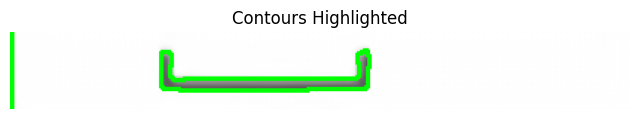

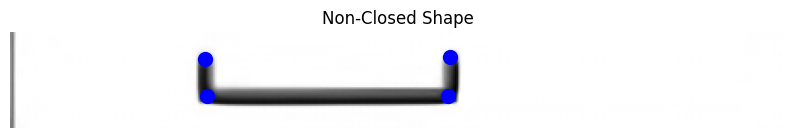

Image: Shapes/row_7.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



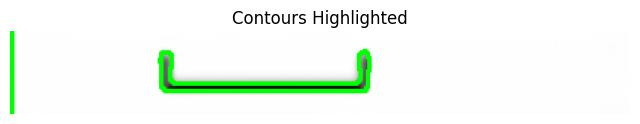

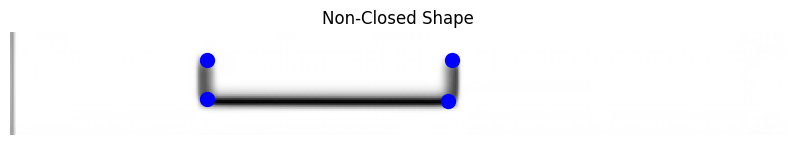

Image: Shapes/row_8.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



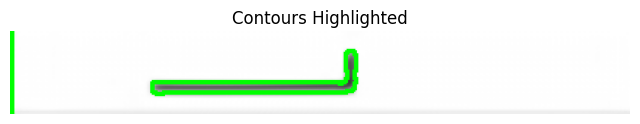

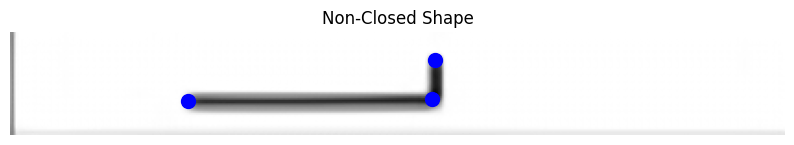

Image: Shapes/row_32.png
Closed Shape: No
Number of corners: 3
Number of bends: 1



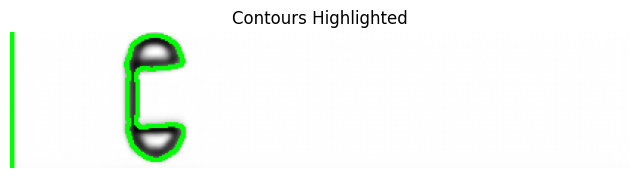

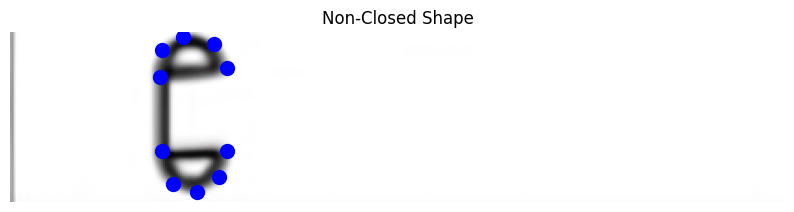

Image: Shapes/row_30.png
Closed Shape: No
Number of corners: 10
Number of bends: 8



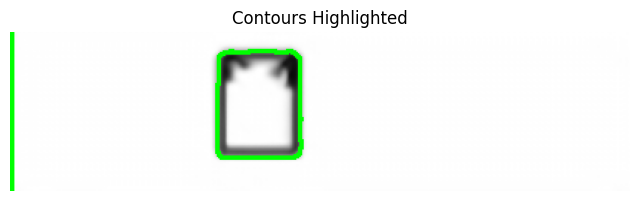

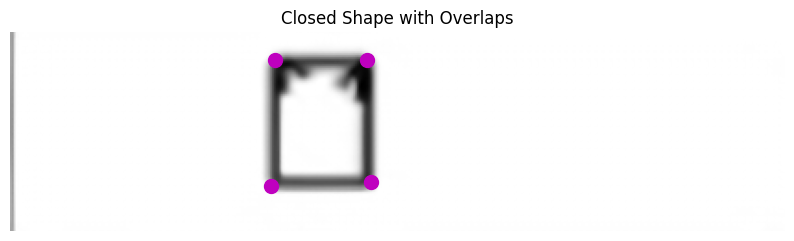

Image: Shapes/row_18.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



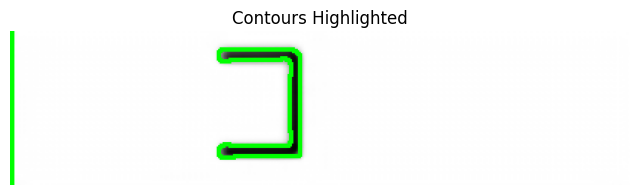

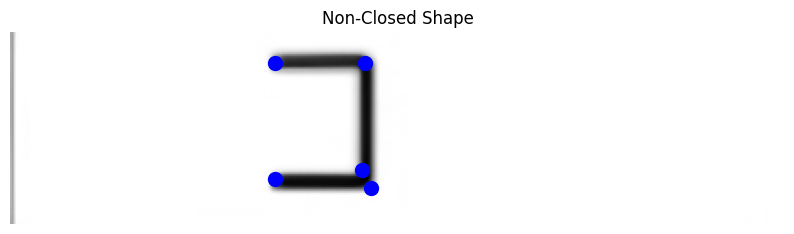

Image: Shapes/row_25.png
Closed Shape: No
Number of corners: 5
Number of bends: 3



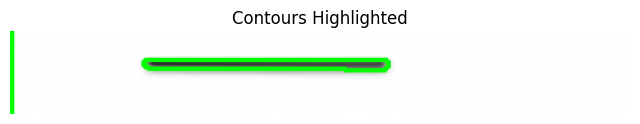

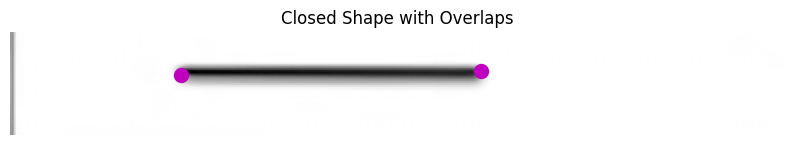

Image: Shapes/row_13.png
Closed Shape: Yes
Number of corners: 2
Number of overlaps: 2
Number of bends: 4

This case is not ideal.



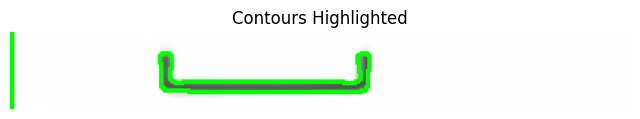

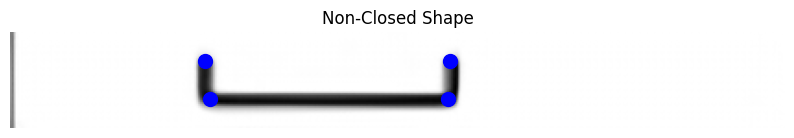

Image: Shapes/row_10.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



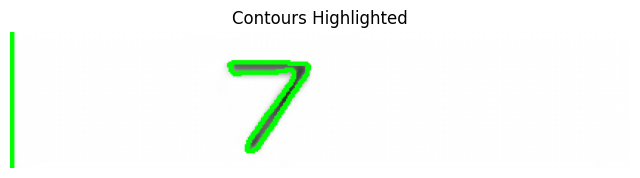

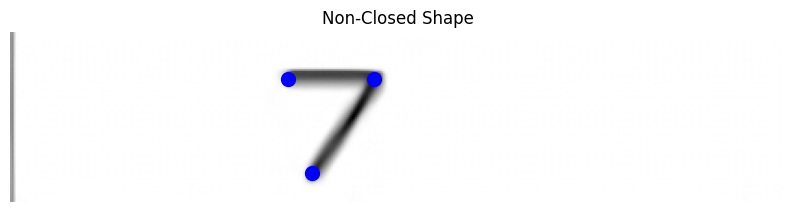

Image: Shapes/row_27.png
Closed Shape: No
Number of corners: 3
Number of bends: 1



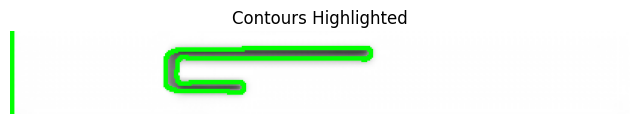

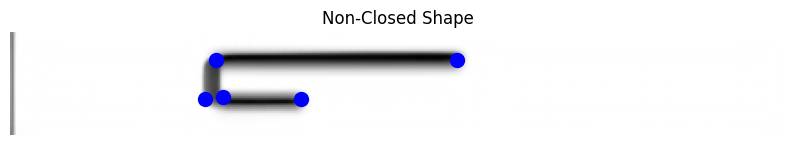

Image: Shapes/row_29.png
Closed Shape: No
Number of corners: 5
Number of bends: 3



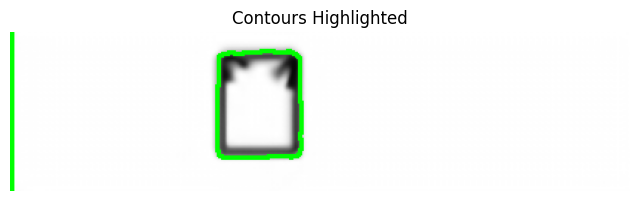

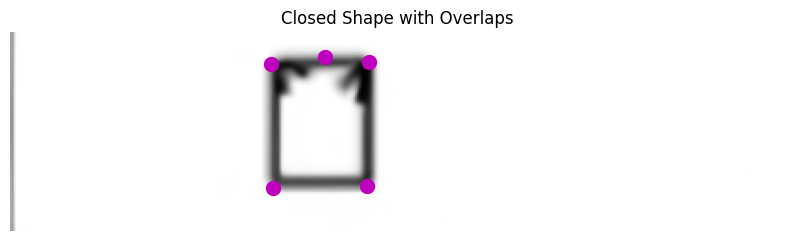

Image: Shapes/row_22.png
Closed Shape: Yes
Number of corners: 5
Number of overlaps: 5
Number of bends: 10

This case is not ideal.



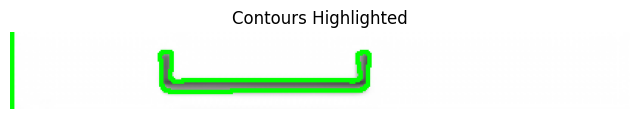

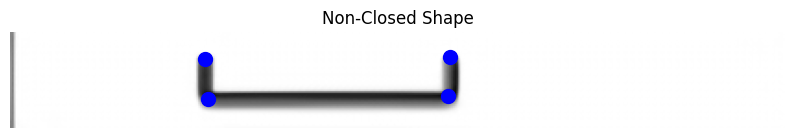

Image: Shapes/row_12.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



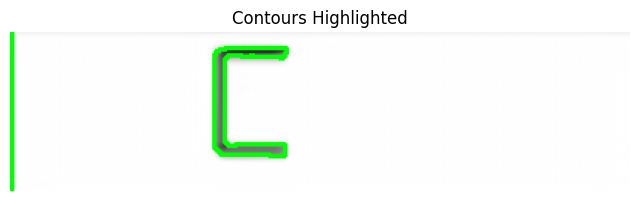

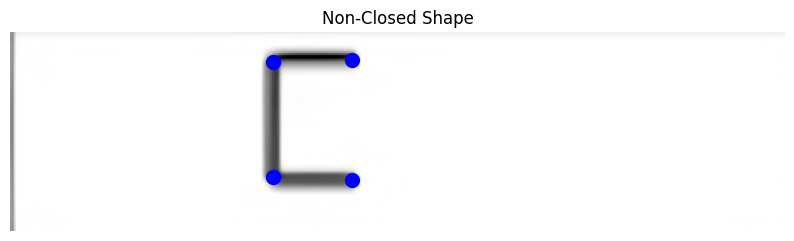

Image: Shapes/row_14.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



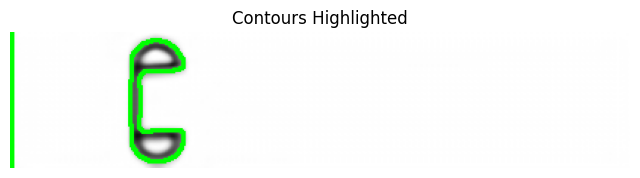

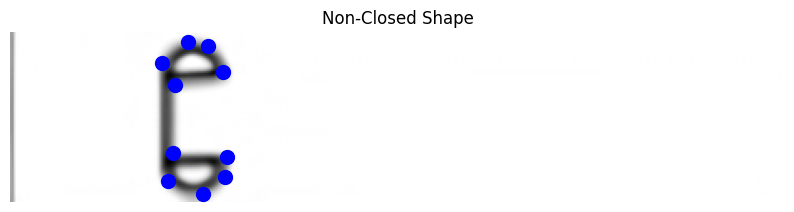

Image: Shapes/row_31.png
Closed Shape: No
Number of corners: 10
Number of bends: 8



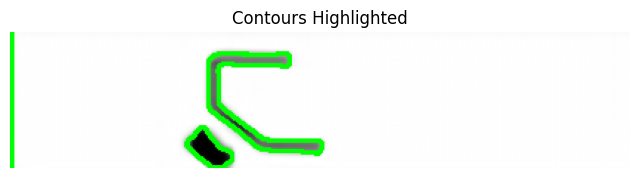

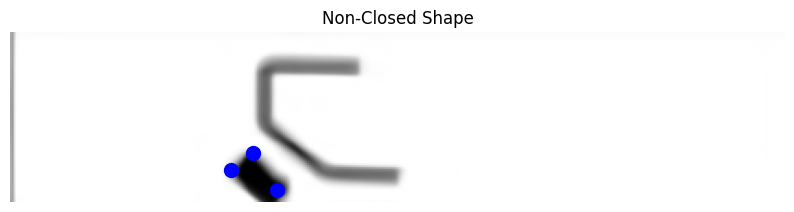

Image: Shapes/row_28.png
Closed Shape: No
Number of corners: 3
Number of bends: 1



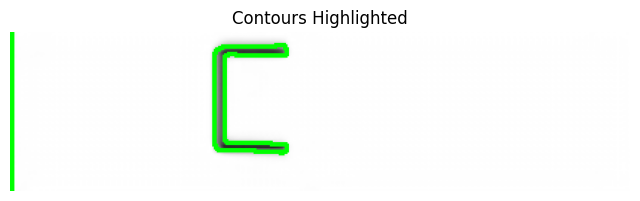

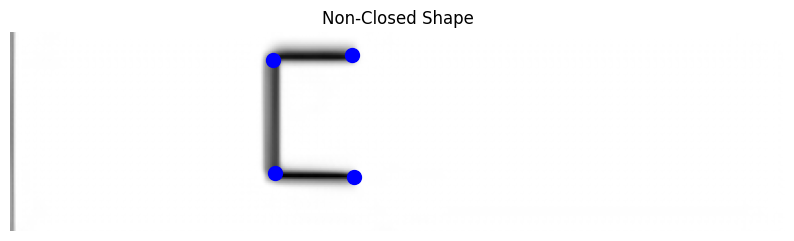

Image: Shapes/row_15.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



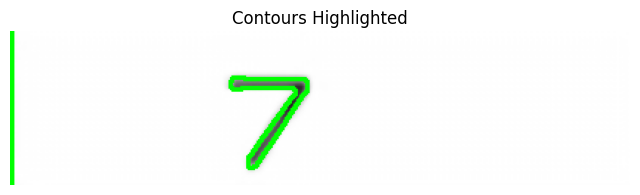

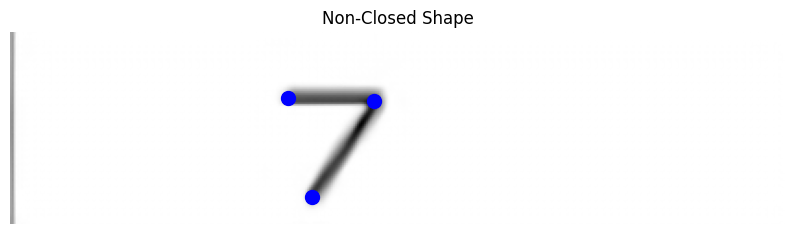

Image: Shapes/row_26.png
Closed Shape: No
Number of corners: 3
Number of bends: 1



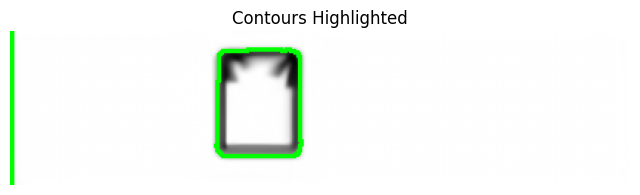

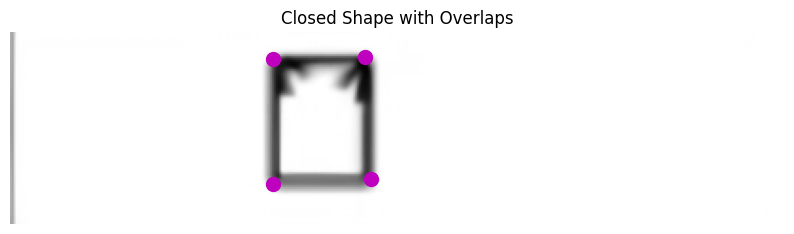

Image: Shapes/row_17.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



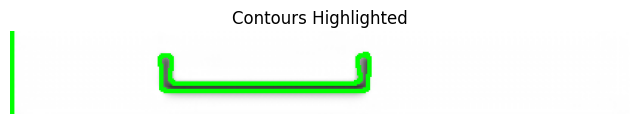

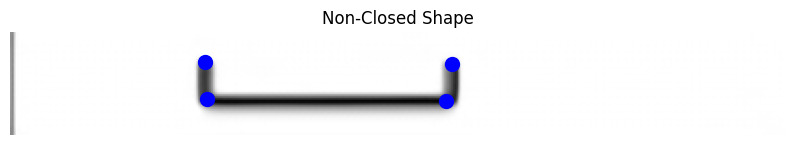

Image: Shapes/row_11.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



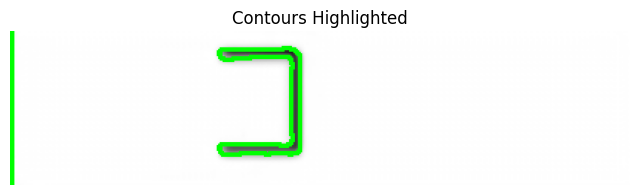

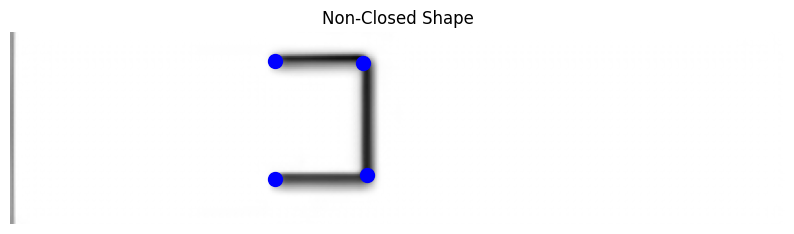

Image: Shapes/row_24.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



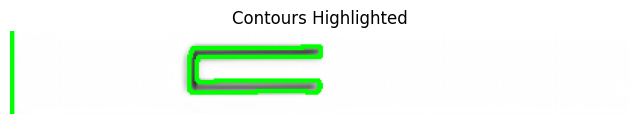

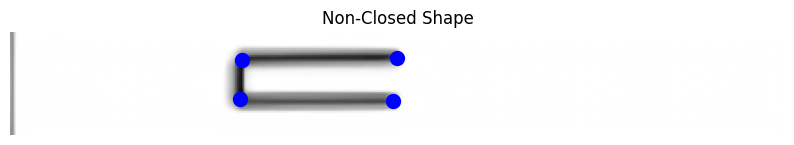

Image: Shapes/row_37.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



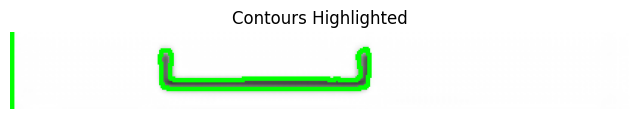

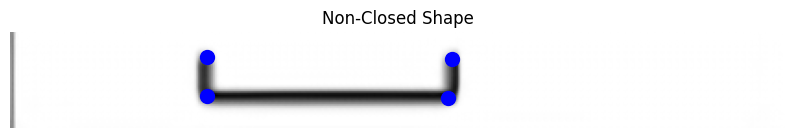

Image: Shapes/row_9.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



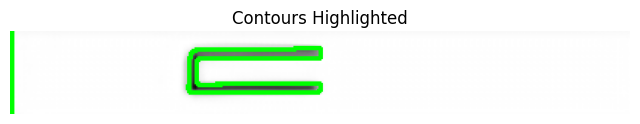

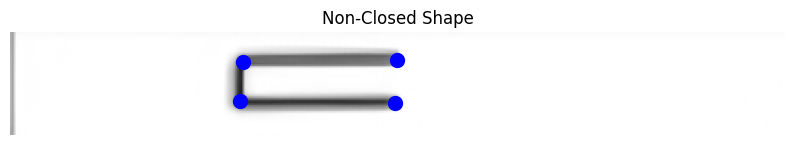

Image: Shapes/row_36.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



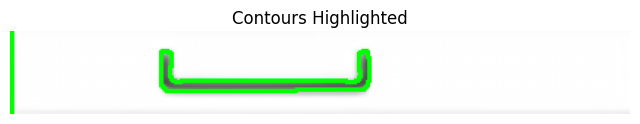

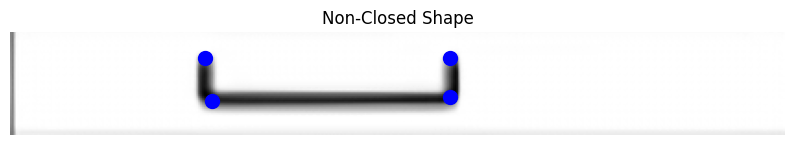

Image: Shapes/row_39.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



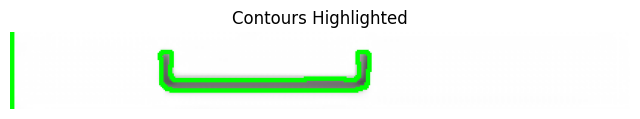

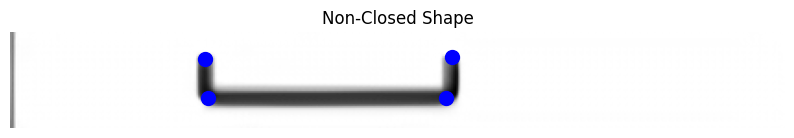

Image: Shapes/row_38.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



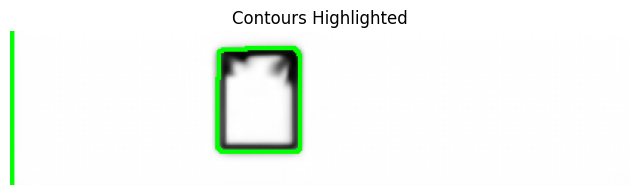

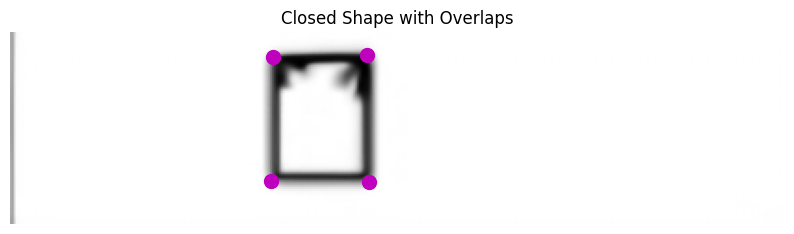

Image: Shapes/row_23.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



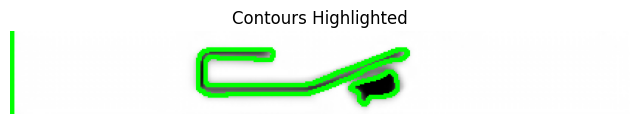

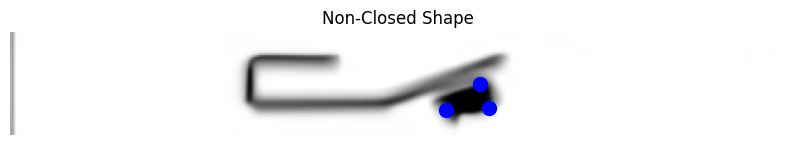

Image: Shapes/row_34.png
Closed Shape: No
Number of corners: 3
Number of bends: 1



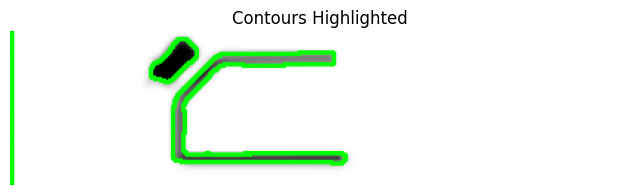

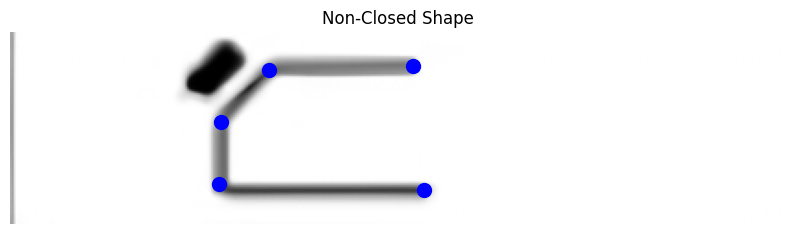

Image: Shapes/row_35.png
Closed Shape: No
Number of corners: 5
Number of bends: 3



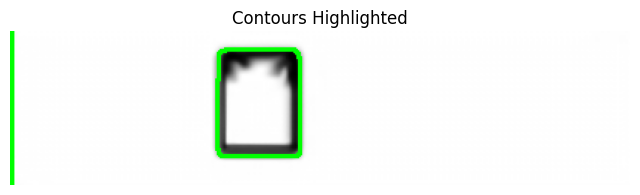

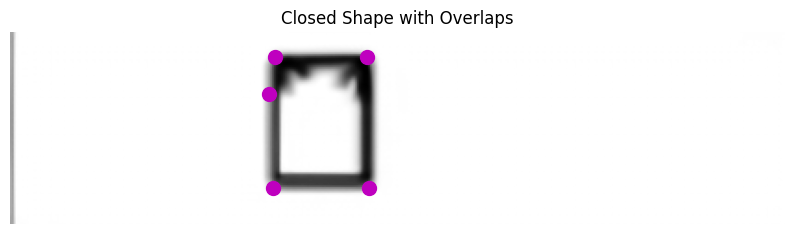

Image: Shapes/row_21.png
Closed Shape: Yes
Number of corners: 5
Number of overlaps: 5
Number of bends: 10

This case is not ideal.



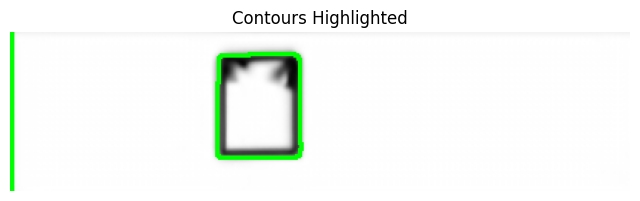

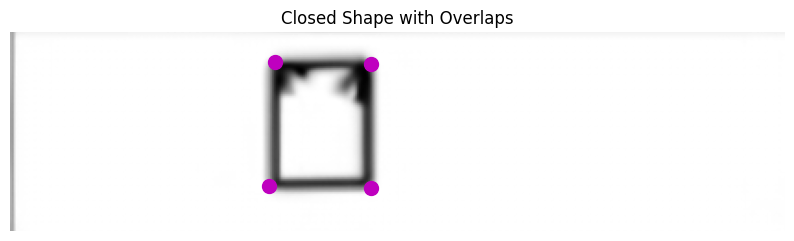

Image: Shapes/row_19.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



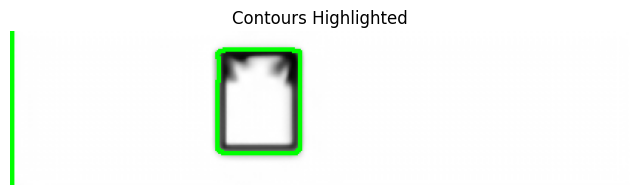

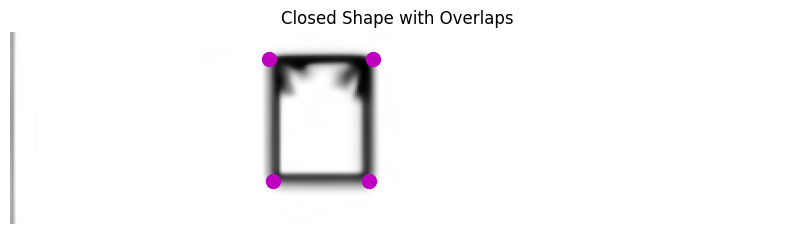

Image: Shapes/row_16.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



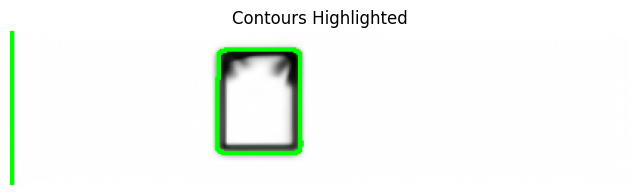

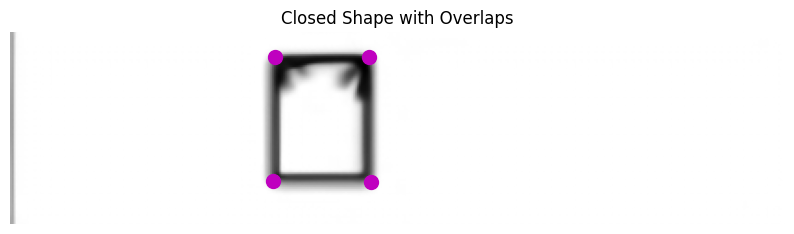

Image: Shapes/row_20.png
Closed Shape: Yes
Number of corners: 4
Number of overlaps: 4
Number of bends: 8

This case is not ideal.



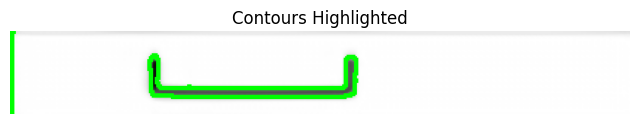

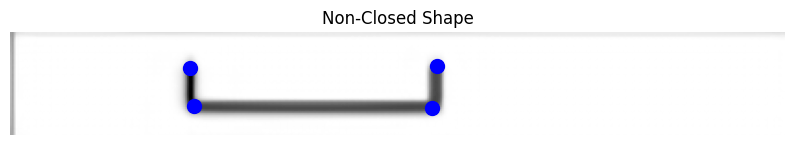

Image: Shapes/row_33.png
Closed Shape: No
Number of corners: 4
Number of bends: 2



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

def preprocess_image(image, kernel_size=(3, 3), blur_ksize=(5, 5), block_size=31, C=10):
    """Preprocess image by applying Gaussian blur and adaptive thresholding."""
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )
    return binary_image

def find_contours(binary_image):
    """Find contours in the binary image."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_corners_from_polygon(contour):
    """Detect corners by approximating the polygon and marking its vertices."""
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2)
    return corners

def cluster_corners(corners, eps=10, min_samples=1):
    """Cluster nearby corners to ensure only one corner per vertex."""
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(corners)
    unique_corners = []
    for label in np.unique(db.labels_):
        cluster_points = corners[db.labels_ == label]
        centroid = np.mean(cluster_points, axis=0).astype(int)
        unique_corners.append(centroid)
    return np.array(unique_corners)

def detect_overlaps(image, corners, area_size=25, threshold=0.5):
    """Detect overlaps around corners based on line-like segments."""
    overlaps = []
    for corner in corners:
        x, y = corner
        area = image[max(0, y - area_size):min(image.shape[0], y + area_size),
                     max(0, x - area_size):min(image.shape[1], x + area_size)]

        # Check for line-like segments (protrusions) around the corner
        # Adjusted approach: Count black pixels in the area and threshold based on density
        black_pixel_count = np.sum(area == 0)  # Count black pixels
        area_size_squared = (2 * area_size) ** 2
        black_pixel_density = black_pixel_count / area_size_squared

        if black_pixel_density > threshold:  # Adjust threshold as needed
            overlaps.append((x, y))

    return overlaps

def is_contour_closed(contour, epsilon_factor=0.01):
    """Check if a contour is closed."""
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return cv2.isContourConvex(approx)

def process_image(image_path, preprocess_params={}):
    """Process a single image and display results."""
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return

        binary_image = preprocess_image(image, **preprocess_params)
        contours = find_contours(binary_image)

        img_height, img_width = binary_image.shape
        filtered_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2:4] != (img_width, img_height)]

        contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), thickness=2)

        plt.figure(figsize=(8, 8))
        plt.imshow(contour_image)
        plt.title('Contours Highlighted')
        plt.axis('off')
        plt.show()

        for contour in filtered_contours:
            if is_contour_closed(contour):
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                overlaps = detect_overlaps(binary_image, corners)
                bends = len(corners) + len(overlaps)

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Closed Shape with Overlaps')
                plt.axis('off')

                for corner in corners:
                    x, y = corner
                    plt.plot(x, y, 'mo' if (x, y) in overlaps else 'bo', ms=10)

                for x, y in overlaps:
                    if (x, y) not in corners:
                        plt.plot(x, y, 'ro', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: Yes")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of overlaps: {len(overlaps)}")
                print(f"Number of bends: {bends}\n")

                if len(overlaps) >= len(corners):
                    print("This case is not ideal.\n")
                break

            else:
                corners = detect_corners_from_polygon(contour)
                corners = cluster_corners(corners)
                bends = len(corners) - 2

                plt.figure(figsize=(10, 10))
                plt.imshow(image, cmap='gray')
                plt.title('Non-Closed Shape')
                plt.axis('off')

                for corner in corners:
                    plt.plot(corner[0], corner[1], 'bo', ms=10)

                plt.show()

                print(f"Image: {image_path}")
                print(f"Closed Shape: No")
                print(f"Number of corners: {len(corners)}")
                print(f"Number of bends: {bends}\n")

                break

    except Exception as e:
        print(f"An error occurred while processing '{image_path}': {e}")

# Folder path containing the images
image_folder = "Shapes"

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        process_image(image_path)


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Folder path containing the cropped images
image_folder = "Shapes"

# Excel output file path
excel_output = "corner_detection_results.xlsx"

# Create an empty list to hold the data for the Excel sheet
data = []

# Gaussian blur parameters
gaussian_ksize = (3, 3)
gaussian_sigma = 0  # Default sigma value for Gaussian blur

# Dilation kernel and iterations
dilation_kernel = np.ones((3, 3), np.uint8)
dilation_iterations = 2  # Number of dilation iterations

# Check if the folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Folder '{image_folder}' does not exist.")

# Get all valid image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# If no image files found, exit early
if not image_files:
    print("No valid image files found in the folder.")
else:
    # Loop through all image files in the folder
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        try:
            # Read the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Failed to read image: {image_file}")
                continue

            # Apply Gaussian blur for noise reduction
            blurred_img = cv2.GaussianBlur(image, gaussian_ksize, gaussian_sigma)

            # Apply dilation to enhance edges
            dilated_img = cv2.dilate(blurred_img, dilation_kernel, dilation_iterations)

            # Shi-Tomasi corner detection
            corners = cv2.goodFeaturesToTrack(
                dilated_img, maxCorners=300, qualityLevel=0.01, minDistance=5
            )

            # Determine the number of corners
            if corners is not None:
                num_corners = len(corners)
                num_bends = max(0, num_corners - 2)  # Avoid negative values

                # Add the data to the list
                data.append({
                    'Image Name': image_file,
                    'Number of Corners': num_corners,
                    'Number of Bends': num_bends
                })

            else:
                # No corners detected, set 0 bends
                data.append({
                    'Image Name': image_file,
                    'Number of Corners': 0,
                    'Number of Bends': 0
                })

        except Exception as e:
            print(f"An error occurred while processing '{image_file}': {e}")

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Save the DataFrame to an Excel file
    df.to_excel(excel_output, index=False)

    print(f"Results saved to '{excel_output}'")
